### Collaborative Filtering

In this notebook, you will get some practice building out a few different methods for making recommendations - including collaborative filtering methods. For simplication, we will be focusing on just the recommendation engine box. Imagine the data is in a drop off zone in the format observed in `ratings.dat`.  

Then, you are asked to create a relative path from the present working directory of this notebook to the path: 

```
../../data/results.json
```

In this path, you should follow the convention of: 

```
{
	"results": [
        {
			"user_id": "1",
			"recs": [8722346, 1502397, 10526632, 3513548, 4082596]
		},

		{
			"user_id": "2",
			"recs": [8722346, 1502397, 10526632, 3513548, 4082596]
		},
        
        ...
	]
}    
                 
```

In the above, each `user_id` corresponds to the value of a user.  The list of values associated with `recs` contains `movie_id`s in the order of highest to lowest recommended movies for the `user_id` listed in the same object. In the above example, you can see there are two users, who are both recommended the same five movies.  

The goal of each of the recommenders in this notebook is to essentially take the initial data and provide a `.json` file in the above format to the `./data/` path.  You will be implementing a number of different recommendation strategies to complete this task.

### Import Data

Start below by reading in the data needed for this task.

In [1]:
import json
import numpy as np
import pandas as pd

ratings_dat = pd.read_csv('../../../data/ratings.dat', sep='::', engine='python', \
                          header=None, names=['user_id', 'movie_id','rating','time'])

ratings_dat.head()

user_id  movie_id  rating        time
0        1   8722346       8  1580754089
1        2   1502397       7  1580809792
2        3  10526632       8  1580676978
3        3   3513548       8  1579462218
4        3   4082596       8  1580945311

**Question 1:** Imagine as a first rating system, you decide to provide the same set of  5 recommendations to each individual.  The rankings for each are in the order from the most ratings to the least.  Use the cell below to provide a list of the 5 movies that will be recommended to each individual.  

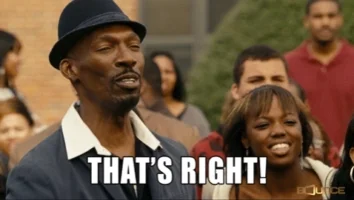

In [2]:
import data_solution_part2 as sp

your_answer = list(ratings_dat.groupby('movie_id').count()['user_id'].sort_values(ascending=False).index[:5])

sp.answer_one(your_answer)

**Question 2:** Now that you have a list of recommendations, you will need to put in the correct format and drop the file in the correct location.  A helper function has been provided to you to perform these tasks, but you should store your results in a dictionary with the format shown below that will be passed to this helper function.  The format of your dictionary should be:

```
{
    1 : [1, 2, 3, 4, 5],
    2 : [1, 2, 3, 4, 5],
    ...
}
```

where the `user_id` is the key and the value is a list of `movie_id`s is provided for each user in order from highest recommendation to lowest recommendation.  

**Reminder:** The recommendations for each user should be the ones generated in the first solution. 

This looks right! You should have the same five ratings for each user_id. And this test passed!


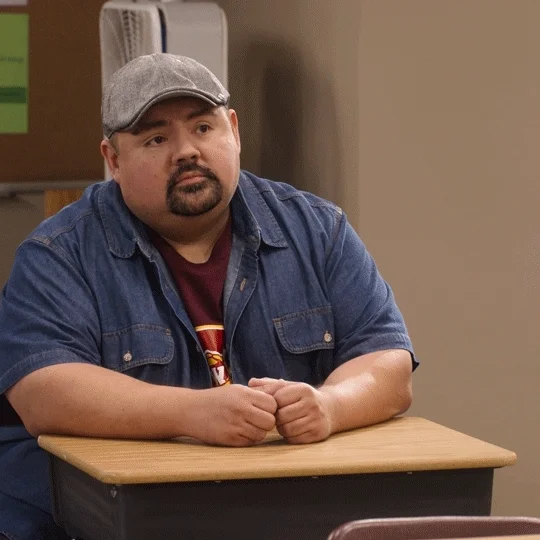

In [3]:
# create a dictionary of your recommendations in the format shown above
# your work here
results_dict = dict()
for user_id in np.unique(ratings_dat['user_id']):
    results_dict[user_id] = your_answer

sp.answer_two(results_dict)

In [4]:
# just run this cell and take a look at the results
from ast import literal_eval

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

def create_json(path = '../../../data/results.json', user_ratings_dict=results_dict):
    '''
    puts a json file at path where user_rartings_dict is of form:
    
        {
            1 : [1, 2, 3, 4, 5],
            2 : [1, 2, 3, 4, 5],
            ...
        }
    
    and stores the results as:
    
        {
            "results": [
                {
                    "user_id": "1",
                    "recs": [8722346, 1502397, 10526632, 3513548, 4082596]
                },

                {
                    "user_id": "2",
                    "recs": [8722346, 1502397, 10526632, 3513548, 4082596]
                },

                ...
            ]
        } 
        
    and returns the json version
    
    '''
    final_results = dict()
    final_results["results"] = []

    for user_id, recs in user_ratings_dict.items():
        entry = dict()
        entry["user"] = str(user_id)
        entry["recs"] = recs
        final_results["results"].append(entry)
    
    final_json = json.dumps(final_results, cls=NpEncoder)
    
    !touch path
    with open(path, "w") as write_file:
        json.dump(final_json, write_file)
        
    with open(path) as f:
        final_json = json.load(f)
    
    return final_json

final_json = create_json()

# print the results 
print(json.dumps(literal_eval(final_json), sort_keys=True, indent=4, separators=(',', ': ')))

{
    "results": [
        {
            "recs": [
                8579674,
                8367814,
                6751668,
                2584384,
                5727208
            ],
            "user": "1"
        },
        {
            "recs": [
                8579674,
                8367814,
                6751668,
                2584384,
                5727208
            ],
            "user": "2"
        },
        {
            "recs": [
                8579674,
                8367814,
                6751668,
                2584384,
                5727208
            ],
            "user": "3"
        },
        {
            "recs": [
                8579674,
                8367814,
                6751668,
                2584384,
                5727208
            ],
            "user": "4"
        },
        {
            "recs": [
                8579674,
                8367814,
                6751668,
                2584384,
                5727208
 

### Graphlab (Turicreate)

One of the most popular libraries for making recommendations is [Graphlab](https://turi.com/products/create/docs/graphlab.toolkits.recommender.html), which was acquired by Apple in 2016 and has the open source [Turicreate](https://apple.github.io/turicreate/docs/userguide/recommender/) used here.  The library allows for recommendations to be made using a number of popular methods without having to think too hard about all the math under the hood (similar to the way sklearn works for popular machine learning methods).

In order to put data in the correct format, run the cell below.

In [5]:
import turicreate as tc

ratings_dat2 = ratings_dat.copy(deep=True)
ratings_dat2.columns = ['user_id', 'item_id', 'rating', 'time']
ratings_sframe = tc.SFrame(ratings_dat2[['user_id', 'item_id', 'rating']])
ratings_sframe.head(5)

Columns:
	user_id	int
	item_id	int
	rating	int

Rows: 5

Data:
+---------+----------+--------+
| user_id | item_id  | rating |
+---------+----------+--------+
|    1    | 8722346  |   8    |
|    2    | 1502397  |   7    |
|    3    | 10526632 |   8    |
|    3    | 3513548  |   8    |
|    3    | 4082596  |   8    |
+---------+----------+--------+
[5 rows x 3 columns]

#### Gaining Familiarity With Turicreate

Now that you have a dataframe that is in the correct format needed for `turicreate` (an `sframe` with a `user_id`, `item_id`, and a `rating`); you will be using the same library to fit a number of different recommendation algorithms.  Below I will walk you through an example, so you will have seen how recommendations are created from start to finish with the `turicreate` library.  You will then answer some questions about these recommendations.  Then, in the next sections, you will use a similar process to provide ratings using the similarity metrics you learned about in the previous notebook.

The code below will walk through an example using the `popularity_recommender`.  The process is similar for making recommendations with any other method:

1. Use `create` to fit your recommender system.


2. Create an `sframe` of `user_id`s for which you would like to make recommendations.


3. Use `recommend` to obtain recommendations for these individuals.


4. Update the format of the recommendations to output structure.

In [6]:
# use create to fit recommendation
m_popular = tc.popularity_recommender.create(ratings_sframe, target='rating')

# create an sframe of user_ids to make recs for
users_test = tc.SFrame({'user_id': [1, 2, 8]})

# use recommend to make recommendations for the set of users
popular_results = m_popular.recommend(users_test)

# update format of output to the json format above
# obtain dictionary similar to earlier in the notebook
results_dict = dict()
for user_id in np.unique(popular_results['user_id']):
    recs = np.array(popular_results[popular_results['user_id'] == user_id]['item_id'])
    results_dict[user_id] = list(recs)
 
# store json        
popularity_json = create_json('../../../data/popularity_results.json', results_dict)

# look at the results
print(json.dumps(literal_eval(popularity_json), sort_keys=True, indent=4, separators=(',', ': ')))

Preparing data set.

Data has 8921 observations with 3287 users and 1945 items.

Data prepared in: 0.017723s

8921 observations to process; with 1945 unique items.

{
    "results": [
        {
            "recs": [
                81353,
                77745,
                96895,
                7121252,
                8985240,
                10472884,
                2797106,
                2910904,
                94898,
                91129
            ],
            "user": "1"
        },
        {
            "recs": [
                81353,
                77745,
                96895,
                7121252,
                8985240,
                10472884,
                2797106,
                2910904,
                94898,
                91129
            ],
            "user": "2"
        },
        {
            "recs": [
                71853,
                87843,
                81353,
                77745,
                96895,
                7121252,
                8985240,
                10472884,
                2797106,
                2910904
            ],
            "user": "8"
        }
    ]
}


**Question 3:** In the previous cell, you will notice that you created reviews for 3 different users.  Use these reviews and the cell below to provide a list of only the letters where the corresponding statement is `True`.  

**Example:** For example `[a, b, c]` would suggest that these three statements are true, but `d` and `e` are `False`.  Please list the letters in the order in which the statements occur.

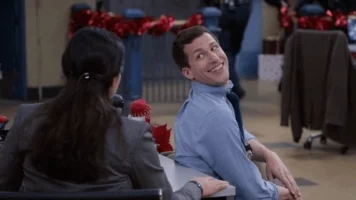

In [7]:
a = "The popularity recommendations are the same across all users."
b = "The popularity recommendations remove movies a user has already watched."
c = "The popularity recommendations are based on the ratings received by each movie."
d = "The recommendations made in question 1 match the popularity recommendations."
e = "The recommendations made in question 1 are based on the ratings received by each movie."

your_answer = [b, c]

# note 'a' isnt true because movies a user has already seen are removed
# note 'd' isnt true because movies in 1 are based on count and popularity is based on rank
# note 'e' isnt true because moveies in 1 are based on on count

sp.answer_three(your_answer)

**Question 4:** Your turn! Now that you have gained some familiarity with the process used to generate recommendations using the `popularity_recommender` based on rating.  Attempt to perform the same process using the `popularity_recommender` without using rating. Then look at recommendations for `user_1` to answer this and the following question.

Preparing data set.

Data has 8921 observations with 3287 users and 1945 items.

Data prepared in: 0.012772s

8921 observations to process; with 1945 unique items.

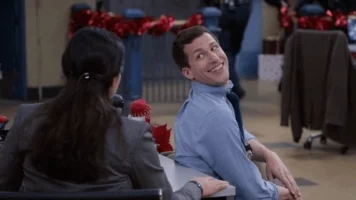

In [8]:
# use create to fit recommendation
model_popular = tc.popularity_recommender.create(ratings_sframe[['user_id', 'item_id']])

# create an sframe of user_ids to make recs for user 1
users_test = tc.SFrame({'user_id': [1]})

# use recommend to make recommendations for the set of users
popular_results = model_popular.recommend(users_test)

# the top 5 recommendations for user_id 1 are:
top_5_recs = popular_results['item_id'][:5]

sp.answer_four(list(top_5_recs))

**Question 5:** Based on the results to the previous question, which of the following statements are `True`.  Provide the letter for each true statement in the list to be checked against the solution. 

**Example:** For example `[a, b]` would suggest that these two statements are true, but `c` is `False`.  Please list the letters in the order in which the statements occur.

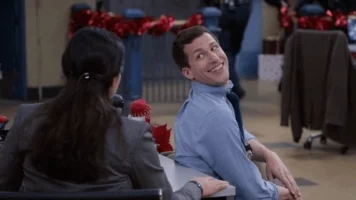

In [9]:
a = "The top 5 recommendations for question 4 are the same as the top 5 for question 1."
b = "Both questions 4 and 1 use recommendations based on the times a movie was watched."
c = "One benefit of using turicreate is that it easily removes movies you've already watched."

your_answer = [a, b, c]

sp.answer_five(your_answer)

Below you can see an example of how each of these individual models would be created:

```
# jaccard
mod_2 = tc.item_similarity_recommender.create(ratings_sframe[['user_id', 'item_id']])

# pearson
mod_1 = tc.item_similarity_recommender.create(ratings_sframe, similarity_type='pearson')

# cosine
mod_1 = tc.item_similarity_recommender.create(ratings_sframe, similarity_type='cosine')
```

**Question 6:** Now as a final recommender technique, use the `item_similarity_recommender` to provide recommendations for the first user and check your answer against the solution below. If no rating is provided, then `jaccard` similaity is used.  The other two possible similarity metrics when ratings are available: `pearson` and `cosine` similarity.

Preparing data set.

Data has 8921 observations with 3287 users and 1945 items.

Data prepared in: 0.012706s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.112ms                        | 30.25      |

| 2.126ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 13.767ms                            | 0                | 0               |

| 32.561ms                            | 100              | 1945            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.04098s

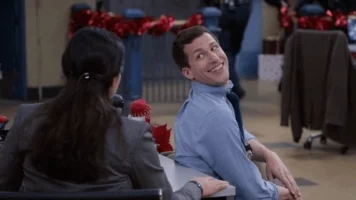

In [10]:
# use create to fit recommendation
model_item = tc.item_similarity_recommender.create(ratings_sframe[['user_id', 'item_id']])

# create an sframe of user_ids to make recs for user 1
users_test = tc.SFrame({'user_id': [1]})

# use recommend to make recommendations for the set of users
item_results = model_item.recommend(users_test)

# the top 5 recommendations for user_id 1 are:
top_5_recs = item_results['item_id'][:5]

sp.answer_six(list(top_5_recs))

You can obtain the 5 most similar users to each user or the 5 most similar items to each each item using the `get_similar_users(k=5)` or `get_similar_items(k=5)` methods on any model.

**Question 7:** Find the 3 most similar users to `user_id` 100 using your popular similarity recommender.

Getting similar users completed in 0.430537

Getting similar users completed in 0.420189

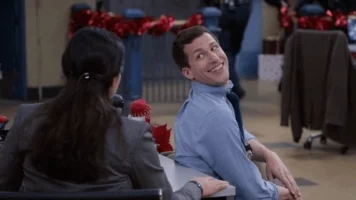

In [11]:
your_answer = list(model_popular.get_similar_users(k=3)[model_popular.get_similar_users(k=3)['user_id'] == 100]['similar'])

sp.answer_seven(your_answer)

**Queestion 8:** Find the 3 most similar items to `item_id` 8404614 using the item similarity model.

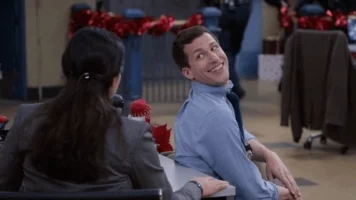

In [12]:
your_answer = list(model_item.get_similar_items(k=3)[model_item.get_similar_items(k=3)['item_id'] == 8404614]['similar'])

sp.answer_eight(your_answer)